# Corny: Density estimation

### TODO
- Modify code below to predict on test set with MSE Loss model, and Custom density loss model
- The outcomes should be dict with keys as the image name and values as the predicted counts (see `test_dict` generated by `count_instances()` below)
- Count MAPE using provided `count_mape()` function
- Plot the predicted counts against the true counts

In [ ]:
import sys
import torch
sys.path.append("../corny/density estimation/")
from unet_smp import UNetLightningModule
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms

checkpoint_path = "../corny/logs/tb_logs/unet_smp/version_15/checkpoints/epoch=99-step=2400.ckpt"
checkpoint = torch.load(checkpoint_path)
hparams = {
    # Model hyperparameters
    "in_channels": 3,
    "out_channels": 1,
    "decoder_channels": (512, 256, 128, 64, 32),
    "learning_rate": 1e-4,
    # Data hyperparameters
    "batch_size": 16,
    "num_workers": 1,
    # Training hyperparameters
    "max_epochs": 10,
    # Paths
    "train_image_dir": "../datasets/corn_kernel_density/train/original_size_dmx100/sigma-12",
    "train_density_map_dir": "../datasets/corn_kernel_density/train/original_size_dmx100/sigma-12",
    "val_image_dir": "../datasets/corn_kernel_density/val/original_size_dmx100/sigma-12",
    "val_density_map_dir": "../datasets/corn_kernel_density/val/original_size_dmx100/sigma-12",
}

# Load model
model = UNetLightningModule(
    in_channels=hparams["in_channels"],
    out_channels=hparams["out_channels"],
    decoder_channels=hparams["decoder_channels"],
    learning_rate=hparams["learning_rate"],
)
model.load_state_dict(checkpoint["state_dict"])

In [17]:
# path to input image
input_image_path = "../corny/datasets/corn_kernel_density/train/original_size_dmx100/sigma-12/corn_004.jpg"
image = Image.open(input_image_path)

# Transform the image (adjust according to how your model was trained)
transform = transforms.Compose([
    transforms.Resize((480, 640)),  # Resize to the expected input size of the model
    transforms.ToTensor(),  # Convert to tensor
    # Normalize if your model expects normalized inputs
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

x = transform(image).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Predict with the model (disable gradient computation for inference)
with torch.no_grad():
    y_hat = model(x)

# `y_hat` is the predicted output from the model

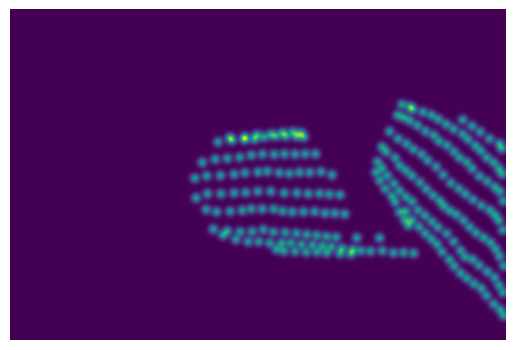

In [3]:
y = np.load("../corny/datasets/corn_kernel_density/train/original_size_dmx100/sigma-12/corn_004_class_0_density.npy")

# Plot the result
plt.figure()
plt.imshow(y)
plt.axis('off') 
plt.show()

In [19]:
# Density maps are scaled up by 100, so /100 to get the true count
torch.sum(y_hat)/100 

tensor(162.7764)

In [12]:
# Ground truth count
np.sum(y)/100

231.0001953125

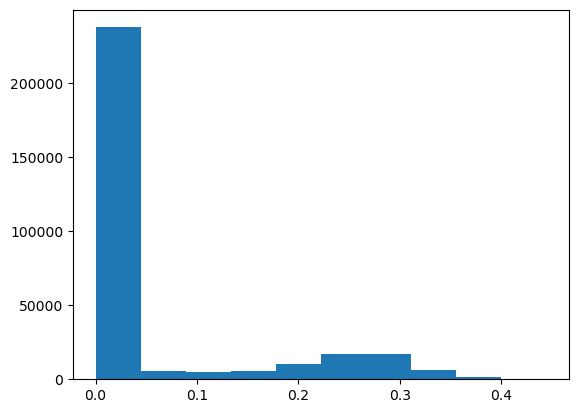

In [20]:
# plot y_hat values in a histogram
plt.figure()
plt.hist(y_hat.flatten())
plt.show()


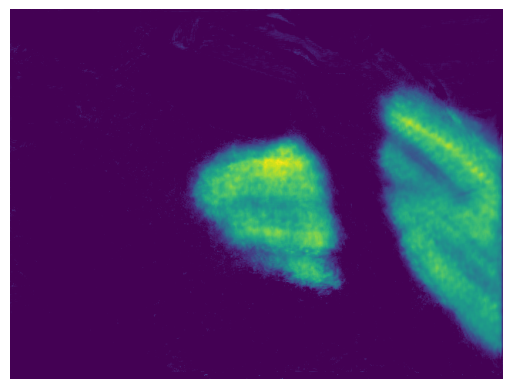

In [21]:
y_hat_np = y_hat.squeeze().numpy()

# Plot the result with custom density map
plt.figure()
plt.imshow(y_hat_np)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
# Given a directory, count the number of annotations/predictions in each label output
def count_instances(dir):
    """
    Count the number of annotated/predicted instances in each label file in the given directory.

    Args:
    - dir (str): The directory containing the label .txt files.

    Returns:
    - counts (dict): A dictionary containing the number of annotated/predicted instances for each image.
    """
    counts = {}
    for file in glob.glob(dir + "*.txt"):
        with open(file, "r") as in_file:
            lines = in_file.readlines()
        counts[Path(file).name] = len(lines)
    return counts

In [ ]:
test_dict = count_instances("../datasets/corn_kernel_yolo/labels/test/")

In [ ]:
# Compute Count MAPE for each model
def count_mape(true_dict, pred_dict):
    """
    Compute the Count Mean Absolute Percentage Error (MAPE) between the true and predicted counts.

    Args:
    - true_dict (dict): A dictionary containing the true number of instances for each image.
    - pred_dict (dict): A dictionary containing the predicted number of instances for each image.

    Returns:
    - mape (float): The Count MAPE between the true and predicted counts.

    Note: The keys in `true_dict` and `pred_dict` are the image filenames and values are the counts.
    """
    mape = 0
    for key in true_dict.keys():
        mape += abs(true_dict.get(key) - pred_dict.get(key,0)) / true_dict.get(key)
    return mape / len(true_dict)

In [ ]:
# Plot predicted vs true counts
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Test set")
fig.supxlabel("True number of kernels")
fig.supylabel("Predicted number of kernels")
gt_values = list(test_dict_sorted.values())
# Truncate axes to 800
ax.set_xlim(0, 800)
ax.set_ylim(0, 800)
# Adam
#ax.scatter(gt_values, [predicted_dict_adam.get(k,0) for k in test_dict_sorted.keys()], label="Adam", alpha=0.7, marker="^")
# AdamW
ax.scatter(gt_values, [predicted_dict_baseline.get(k,0) for k in test_dict_sorted.keys()], label="AdamW", alpha=0.7, marker="o")
# SGD
#ax.scatter(gt_values, [predicted_dict_sgd.get(k,0) for k in test_dict_sorted.keys()], label="SGD", alpha=0.7, marker="s")
plt.legend(loc="upper left")